In [ ]:
import time
import copy
import matplotlib.pyplot as plt
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.callbacks.openai_info import OpenAICallbackHandler
import numpy as np

class ChatManager:
    def __init__(self, model_name="gpt-4o-mini"):
        """Initializes the Chat Manager with memory, LLM model, and token tracking."""
        self.model_name = model_name
        self.chat_versions = []
        self.current_version = None

        # ✅ Global storage for ALL token usage across chat versions
        self.token_usage_history = {
            "steps": [],
            "cumulative_tokens": [],
            "cumulative_prompt_tokens": [],
            "cumulative_completion_tokens": [],
            "individual_total_tokens": [],
            "individual_prompt_tokens": [],
            "individual_completion_tokens": []
        }

        self._initialize_llm_and_tracking()

        # Create initial empty version (Version 0)
        self._create_initial_version()

        self.change_log = []  # Log changes like restores and deletions

    def _initialize_llm_and_tracking(self):
        """Sets up LLM, memory, and ensures token tracking is updated correctly."""
        self.callback_handler = OpenAICallbackHandler()
        self.llm = ChatOpenAI(model_name=self.model_name, callbacks=[self.callback_handler])
        self.memory = ConversationBufferMemory(return_messages=True)
        self.prompt = self._create_prompt_template()
        self.chain = LLMChain(llm=self.llm, prompt=self.prompt, memory=self.memory, verbose=False)

    def _create_initial_version(self):
        """Creates the initial empty version (Version 0)."""
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        # Create Version 0 with no messages to mark the starting point of the conversation
        self.chat_versions.append((timestamp, []))  # Initial empty version
        self.current_version = 0  # The current version is Version 0

    def _create_prompt_template(self):
        """Defines the chat prompt format."""
        template = """
        The following is a friendly conversation between an intelligent chatbot and a human.
        Chatbot: {history}
        Human: {input}
        Chatbot:
        """
        return PromptTemplate(template=template, input_variables=["history", "input"])

    def process_user_input(self, user_input):
        """Processes user input, updates chat memory, and tracks token usage."""
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

        # Generate a response from the model
        result = self.chain.invoke(user_input)

        # Add current memory (chat history) to versions list after processing
        self.chat_versions.append((timestamp, copy.deepcopy(self.memory.chat_memory.messages)))
        self.current_version = len(self.chat_versions) - 1

        # Track token usage after processing the input
        self._track_token_usage()
        
        return result

    def _track_token_usage(self, is_reset=False):
        """Tracks token usage while preserving chat history. Handles resets properly."""
        total_used = self.callback_handler.total_tokens
        prompt_used = self.callback_handler.prompt_tokens
        completion_used = self.callback_handler.completion_tokens

        # 🛠️ Get last known cumulative values (before reset)
        prev_total = self.token_usage_history["cumulative_tokens"][-1] if self.token_usage_history["cumulative_tokens"] else 0
        prev_prompt = self.token_usage_history["cumulative_prompt_tokens"][-1] if self.token_usage_history["cumulative_prompt_tokens"] else 0
        prev_completion = self.token_usage_history["cumulative_completion_tokens"][-1] if self.token_usage_history["cumulative_completion_tokens"] else 0

        # 🛠️ Handle Reset Properly
        if is_reset:
            # Instead of resetting to zero, continue tracking smoothly
            self.last_known_cumulative = {
                "total": total_used,
                "prompt": prompt_used,
                "completion": completion_used
            }
            return  # Don't log a new step yet; let the next request handle it correctly

        # Adjust first step after reset to avoid zero dip
        if hasattr(self, "last_known_cumulative"):
            prev_total = self.last_known_cumulative["total"]
            prev_prompt = self.last_known_cumulative["prompt"]
            prev_completion = self.last_known_cumulative["completion"]
            del self.last_known_cumulative  # Ensure it's only used once

        # Ensure no negative values appear
        individual_total = max(0, total_used - prev_total)
        individual_prompt = max(0, prompt_used - prev_prompt)
        individual_completion = max(0, completion_used - prev_completion)

        # Store new token usage values
        steps = len(self.token_usage_history["steps"]) + 1
        self.token_usage_history["steps"].append(steps)
        self.token_usage_history["cumulative_tokens"].append(total_used)
        self.token_usage_history["cumulative_prompt_tokens"].append(prompt_used)
        self.token_usage_history["cumulative_completion_tokens"].append(completion_used)
        self.token_usage_history["individual_total_tokens"].append(individual_total)
        self.token_usage_history["individual_prompt_tokens"].append(individual_prompt)
        self.token_usage_history["individual_completion_tokens"].append(individual_completion)

    def show_chat_versions(self):
        """Displays all chat versions saved so far."""
        print("\n📜 Chat Versions:")
        for i, (timestamp, _) in enumerate(self.chat_versions):
            mark = " (In Use) 🔵" if i == self.current_version else ""
            print(f"Version {i}: {timestamp}{mark}")

    def show_version_messages(self, version_number):
        """Displays all messages from a specific chat version."""
        if 0 <= version_number < len(self.chat_versions):
            print(f"\n🗂️ Messages in Version {version_number}:")
            for i, msg in enumerate(self.chat_versions[version_number][1]):
                print(f"{i}. {msg.type}: {msg.content}")
        else:
            print("⚠️ Invalid version number!")

    def restore_chat_version(self, version_number):
        """Restores a previous chat version while maintaining full token tracking history."""
        if 0 <= version_number < len(self.chat_versions):
            self.memory.clear()  # Fully clear memory before restoring

            for msg in self.chat_versions[version_number][1]:
                if msg.type == "human":
                    self.memory.chat_memory.add_user_message(msg.content)
                else:
                    self.memory.chat_memory.add_ai_message(msg.content)

            self.current_version = version_number
            self._initialize_llm_and_tracking()

            # 🛠️ Reset token usage tracking to avoid negative values
            self._track_token_usage(is_reset=True)

            # Log the restoration with timestamp and version number
            change_timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())  # Capture the time of the restoration
            self.change_log.append(f"[{change_timestamp}] Restored to Version {version_number}.")

            print(f"✅ Successfully restored to Version {version_number}. Token tracking corrected.")
        else:
            print("⚠️ Invalid version number!")


    def delete_chat_messages(self, indexes_to_delete):
        """Deletes selected messages but keeps full token tracking history."""
        latest_messages = copy.deepcopy(self.memory.chat_memory.messages)

        if not latest_messages:
            print("⚠️ No messages to delete!")
            return

        # 🔹 Ensure we only delete valid indexes
        valid_indexes = [i for i in indexes_to_delete if 0 <= i < len(latest_messages)]
        if not valid_indexes:
            print("⚠️ No valid messages to delete! Operation ignored.")
            return

        # ✅ Log before deletion
        print(f"Deleting indexes: {valid_indexes}. Messages before deletion: {len(latest_messages)}")

        # 🔹 Keep only messages that are NOT being deleted
        new_version_messages = [msg for i, msg in enumerate(latest_messages) if i not in valid_indexes]

        # ✅ Log after deletion
        print(f"Messages after deletion: {len(new_version_messages)}")

        # 🔹 Fully clear memory
        self.memory.clear()

        # 🔹 Restore only the remaining messages
        for msg in new_version_messages:
            if msg.type == "human":
                self.memory.chat_memory.add_user_message(msg.content)
            else:
                self.memory.chat_memory.add_ai_message(msg.content)

        # 🔹 Save this new version
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        self.chat_versions.append((timestamp, copy.deepcopy(new_version_messages)))
        self.current_version = len(self.chat_versions) - 1

        # Log the change, including the version number and timestamp
        change_timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())  # Capture the time of the change
        self.change_log.append(f"[{change_timestamp}] Deleted messages at indexes: {valid_indexes} from Version {self.current_version}.")
        print(f"✅ Created new version {self.current_version} after deletion! Remaining messages: {len(self.memory.chat_memory.messages)}")

    def show_usage_plots(self):
        """Displays both total token usage as a line plot and stacked token usage as a bar chart on the same plot."""
        fig, ax = plt.subplots(figsize=(10, 6))  # Single plot for both line and bar chart

        # X positions for each set of bars (same as number of steps)
        index = np.arange(len(self.token_usage_history["steps"]))  
        bar_width = 0.5  # Width of each bar

        # Stacked bar chart for Prompt & Completion Tokens
        ax.bar(index, self.token_usage_history["individual_prompt_tokens"], bar_width, label="Prompt Tokens", color="green")
        ax.bar(index, self.token_usage_history["individual_completion_tokens"], bar_width, 
            bottom=self.token_usage_history["individual_prompt_tokens"], label="Completion Tokens", color="red")

        # Line plot for Total Token Usage (on top of the bar chart)
        ax.plot(index, self.token_usage_history["cumulative_tokens"], label="Total Tokens", color="blue", marker="o", linewidth=2)

        # Labels and titles
        ax.set_title("Token Usage (Total, Prompt, and Completion)")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Tokens")
        ax.set_xticks(index)
        ax.set_xticklabels(self.token_usage_history["steps"])

        # Ensure the x-axis labels are aligned to the right
        plt.xticks(rotation=45, ha='right')

        ax.legend()
        ax.grid(True, axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()  # Adjust layout to avoid overlaps
        plt.show()
    
    def show_change_log(self):
        """Displays the log of changes (restores, deletions, etc.)."""
        print("\n📝 Change Log:")
        if self.change_log:
            for entry in self.change_log:
                print(f"- {entry}")
        else:
            print("⚠️ No changes recorded.")




In [211]:
chat_manager = ChatManager()

In [212]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")


{'input': 'What is AI?',
 'history': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm doing great, thank you! How about you?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AIMessage(content="Why don\'t scientists trust atoms? Because they make up everything!", additional_kwargs={}, response_metadata={})', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This encompasses various technologies and methodologies, including machine learning, natural language processing, and robotics, among others. AI can perform tasks such as understanding language, recognizing patterns, solving pr

In [213]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 13:07:23
Version 1: 2025-03-26 13:07:23
Version 2: 2025-03-26 13:07:24
Version 3: 2025-03-26 13:07:25 (In Use) 🔵


In [214]:
chat_manager.show_version_messages(0)


🗂️ Messages in Version 0:


In [215]:
chat_manager.show_version_messages(1)


🗂️ Messages in Version 1:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?


In [216]:
chat_manager.show_version_messages(2)


🗂️ Messages in Version 2:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. ai: AIMessage(content="Why don't scientists trust atoms? Because they make up everything!", additional_kwargs={}, response_metadata={})


In [217]:
chat_manager.show_version_messages(3)


🗂️ Messages in Version 3:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. ai: AIMessage(content="Why don't scientists trust atoms? Because they make up everything!", additional_kwargs={}, response_metadata={})
4. human: What is AI?
5. ai: AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This encompasses various technologies and methodologies, including machine learning, natural language processing, and robotics, among others. AI can perform tasks such as understanding language, recognizing patterns, solving problems, and even making decisions. What aspect of AI are you curious about?


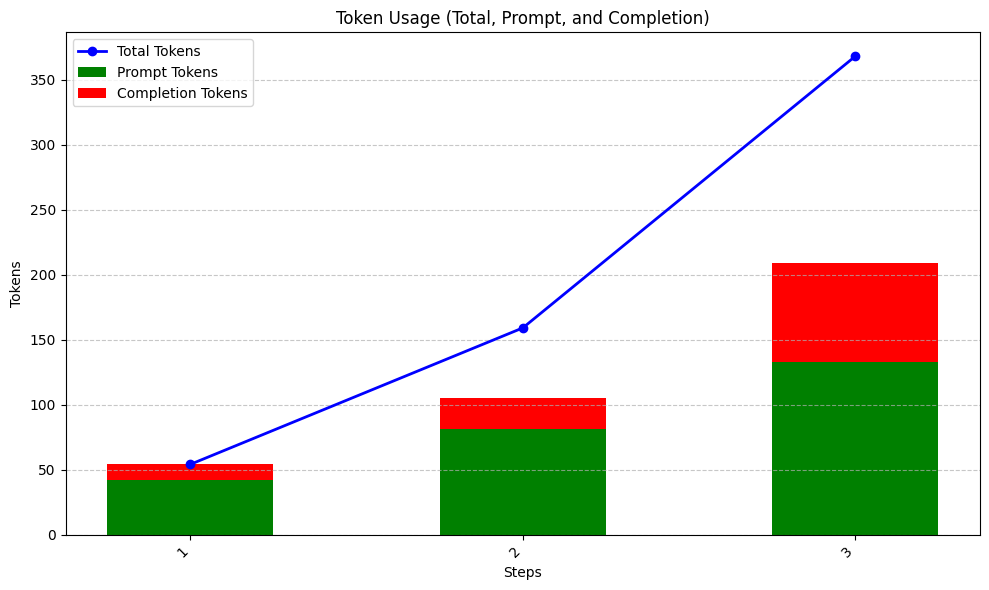

In [218]:
chat_manager.show_usage_plots()

In [219]:
chat_manager.restore_chat_version(0)

✅ Successfully restored to Version 0. Token tracking corrected.


In [220]:
chat_manager.show_change_log()


📝 Change Log:
- [2025-03-26 13:07:29] Restored to Version 0.


In [221]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")

{'input': 'What is AI?',
 'history': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm doing great, thank you! How about you?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AIMessage(content="Why did the scarecrow win an award? Because he was outstanding in his field!", additional_kwargs={}, response_metadata={})', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This includes tasks such as problem-solving, understanding natural language, recognizing patterns, and making decisions. There are various types of AI, ranging from simple rule-based systems to more advanced machine le

In [222]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 13:07:23
Version 1: 2025-03-26 13:07:23
Version 2: 2025-03-26 13:07:24
Version 3: 2025-03-26 13:07:25
Version 4: 2025-03-26 13:07:30
Version 5: 2025-03-26 13:07:31
Version 6: 2025-03-26 13:07:32 (In Use) 🔵


In [223]:
chat_manager.show_version_messages(4)


🗂️ Messages in Version 4:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?


In [224]:
chat_manager.show_version_messages(5)


🗂️ Messages in Version 5:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. ai: AIMessage(content="Why did the scarecrow win an award? Because he was outstanding in his field!", additional_kwargs={}, response_metadata={})


In [225]:
chat_manager.show_version_messages(6)


🗂️ Messages in Version 6:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. ai: AIMessage(content="Why did the scarecrow win an award? Because he was outstanding in his field!", additional_kwargs={}, response_metadata={})
4. human: What is AI?
5. ai: AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This includes tasks such as problem-solving, understanding natural language, recognizing patterns, and making decisions. There are various types of AI, ranging from simple rule-based systems to more advanced machine learning models that can improve their performance over time. What aspect of AI are you most interested in?


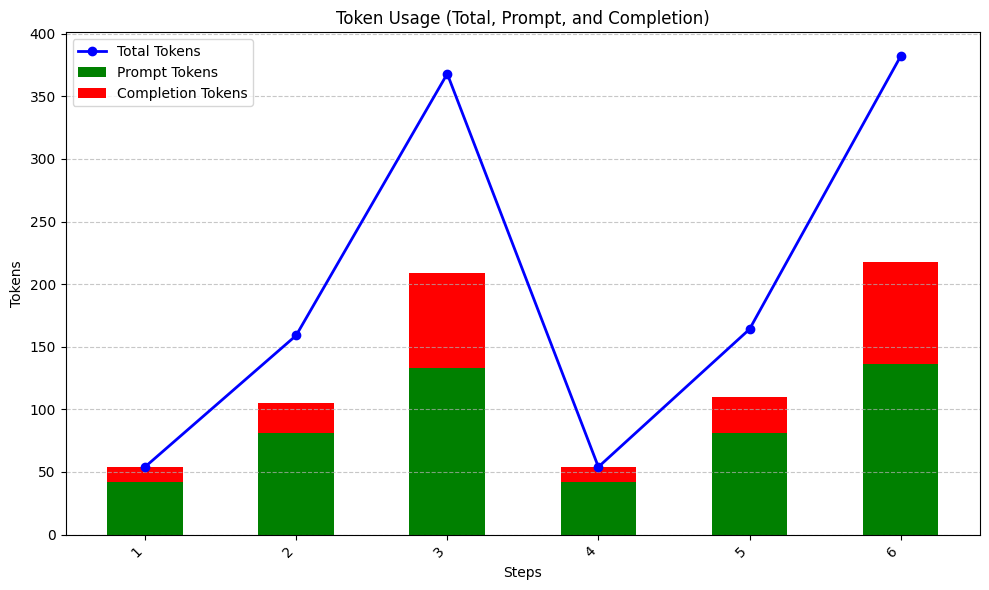

In [226]:
chat_manager.show_usage_plots()

In [227]:
chat_manager.show_change_log()


📝 Change Log:
- [2025-03-26 13:07:29] Restored to Version 0.


In [228]:

chat_manager.show_version_messages(chat_manager.current_version)


🗂️ Messages in Version 6:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. ai: AIMessage(content="Why did the scarecrow win an award? Because he was outstanding in his field!", additional_kwargs={}, response_metadata={})
4. human: What is AI?
5. ai: AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This includes tasks such as problem-solving, understanding natural language, recognizing patterns, and making decisions. There are various types of AI, ranging from simple rule-based systems to more advanced machine learning models that can improve their performance over time. What aspect of AI are you most interested in?


In [229]:
chat_manager.delete_chat_messages([3])

Deleting indexes: [3]. Messages before deletion: 6
Messages after deletion: 5
✅ Created new version 7 after deletion! Remaining messages: 5


In [230]:
chat_manager.show_version_messages(7)


🗂️ Messages in Version 7:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. human: What is AI?
4. ai: AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This includes tasks such as problem-solving, understanding natural language, recognizing patterns, and making decisions. There are various types of AI, ranging from simple rule-based systems to more advanced machine learning models that can improve their performance over time. What aspect of AI are you most interested in?


In [231]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")

{'input': 'What is AI?',
 'history': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm doing great, thank you! How about you?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This includes tasks such as problem-solving, understanding natural language, recognizing patterns, and making decisions. There are various types of AI, ranging from simple rule-based systems to more advanced machine learning models that can improve their performance over time. What aspect of AI are you most interested in?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Hello, how are you?', additional_

In [232]:
chat_manager.show_version_messages(chat_manager.current_version)


🗂️ Messages in Version 10:
0. human: Hello, how are you?
1. ai: I'm doing great, thank you! How about you?
2. human: Tell me a joke.
3. human: What is AI?
4. ai: AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This includes tasks such as problem-solving, understanding natural language, recognizing patterns, and making decisions. There are various types of AI, ranging from simple rule-based systems to more advanced machine learning models that can improve their performance over time. What aspect of AI are you most interested in?
5. human: Hello, how are you?
6. ai: I'm doing great, thank you! How about you?
7. human: Tell me a joke.
8. ai: Sure! Here’s a joke for you: 

Why did the scarecrow win an award? 

Because he was outstanding in his field! 

Hope that brought a smile to your face! Would you like to hear another one?
9. human: What is AI?
10. ai: AI, or artificial intelligence, refers 

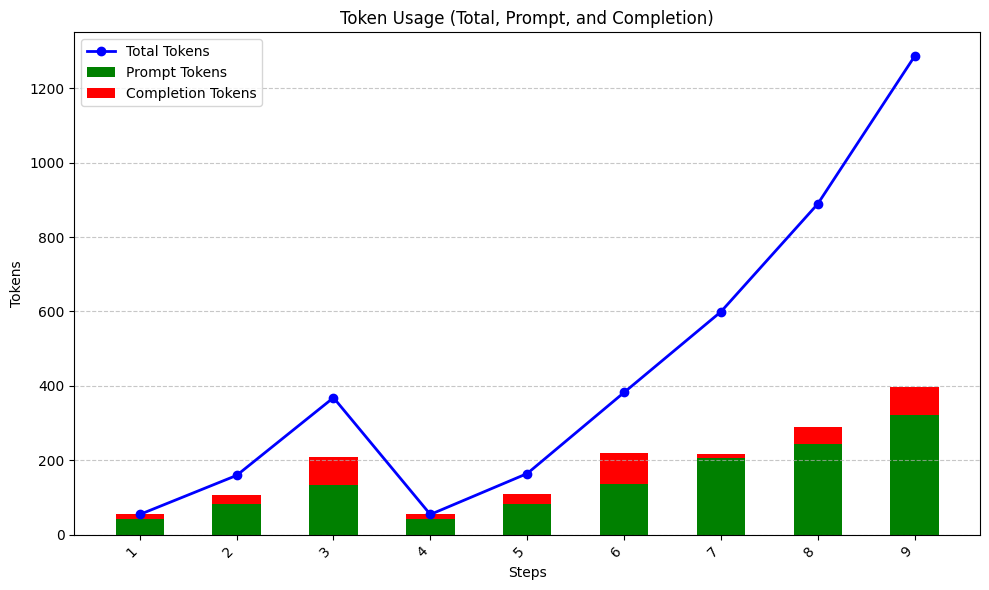

In [233]:
chat_manager.show_usage_plots()

In [234]:
chat_manager.show_change_log()


📝 Change Log:
- [2025-03-26 13:07:29] Restored to Version 0.
- [2025-03-26 13:07:39] Deleted messages at indexes: [3] from Version 7.


In [235]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 13:07:23
Version 1: 2025-03-26 13:07:23
Version 2: 2025-03-26 13:07:24
Version 3: 2025-03-26 13:07:25
Version 4: 2025-03-26 13:07:30
Version 5: 2025-03-26 13:07:31
Version 6: 2025-03-26 13:07:32
Version 7: 2025-03-26 13:07:39
Version 8: 2025-03-26 13:07:40
Version 9: 2025-03-26 13:07:41
Version 10: 2025-03-26 13:07:43 (In Use) 🔵


In [236]:
chat_manager.restore_chat_version(0)

✅ Successfully restored to Version 0. Token tracking corrected.


In [237]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")

{'input': 'What is AI?',
 'history': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm doing well, thank you! How about you?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AIMessage(content="Why don\'t scientists trust atoms? Because they make up everything!", additional_kwargs={}, response_metadata={})', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This can include various capabilities such as problem-solving, understanding natural language, recognizing patterns, and making decisions. AI can be categorized into narrow AI, which is designed for specific tasks (like chatbots

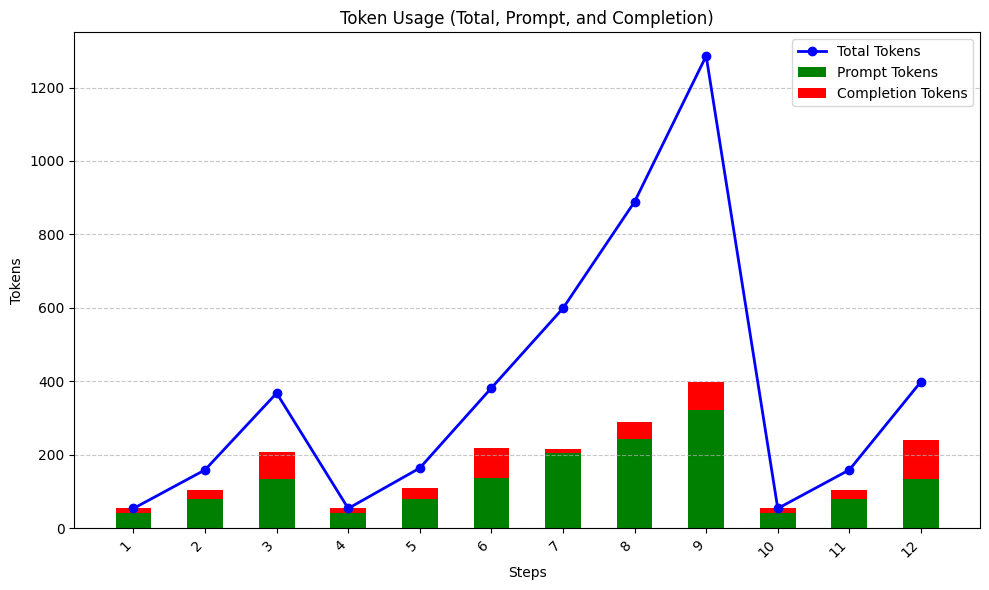

In [238]:
chat_manager.show_usage_plots()

In [239]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 13:07:23
Version 1: 2025-03-26 13:07:23
Version 2: 2025-03-26 13:07:24
Version 3: 2025-03-26 13:07:25
Version 4: 2025-03-26 13:07:30
Version 5: 2025-03-26 13:07:31
Version 6: 2025-03-26 13:07:32
Version 7: 2025-03-26 13:07:39
Version 8: 2025-03-26 13:07:40
Version 9: 2025-03-26 13:07:41
Version 10: 2025-03-26 13:07:43
Version 11: 2025-03-26 13:07:46
Version 12: 2025-03-26 13:07:47
Version 13: 2025-03-26 13:07:48 (In Use) 🔵


In [240]:
chat_manager.delete_chat_messages([3])

Deleting indexes: [3]. Messages before deletion: 6
Messages after deletion: 5
✅ Created new version 14 after deletion! Remaining messages: 5


In [241]:
chat_manager.delete_chat_messages([0])

Deleting indexes: [0]. Messages before deletion: 5
Messages after deletion: 4
✅ Created new version 15 after deletion! Remaining messages: 4


In [242]:
chat_manager.show_change_log()


📝 Change Log:
- [2025-03-26 13:07:29] Restored to Version 0.
- [2025-03-26 13:07:39] Deleted messages at indexes: [3] from Version 7.
- [2025-03-26 13:07:46] Restored to Version 0.
- [2025-03-26 13:07:49] Deleted messages at indexes: [3] from Version 14.
- [2025-03-26 13:07:50] Deleted messages at indexes: [0] from Version 15.


In [243]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 13:07:23
Version 1: 2025-03-26 13:07:23
Version 2: 2025-03-26 13:07:24
Version 3: 2025-03-26 13:07:25
Version 4: 2025-03-26 13:07:30
Version 5: 2025-03-26 13:07:31
Version 6: 2025-03-26 13:07:32
Version 7: 2025-03-26 13:07:39
Version 8: 2025-03-26 13:07:40
Version 9: 2025-03-26 13:07:41
Version 10: 2025-03-26 13:07:43
Version 11: 2025-03-26 13:07:46
Version 12: 2025-03-26 13:07:47
Version 13: 2025-03-26 13:07:48
Version 14: 2025-03-26 13:07:49
Version 15: 2025-03-26 13:07:50 (In Use) 🔵


In [244]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")

{'input': 'What is AI?',
 'history': [AIMessage(content="I'm doing well, thank you! How about you?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This can include various capabilities such as problem-solving, understanding natural language, recognizing patterns, and making decisions. AI can be categorized into narrow AI, which is designed for specific tasks (like chatbots or recommendation systems), and general AI, which would have the ability to understand and reason across a wide range of tasks, similar to a human. Would you like to know more about a specific area of AI?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Hello, how are 

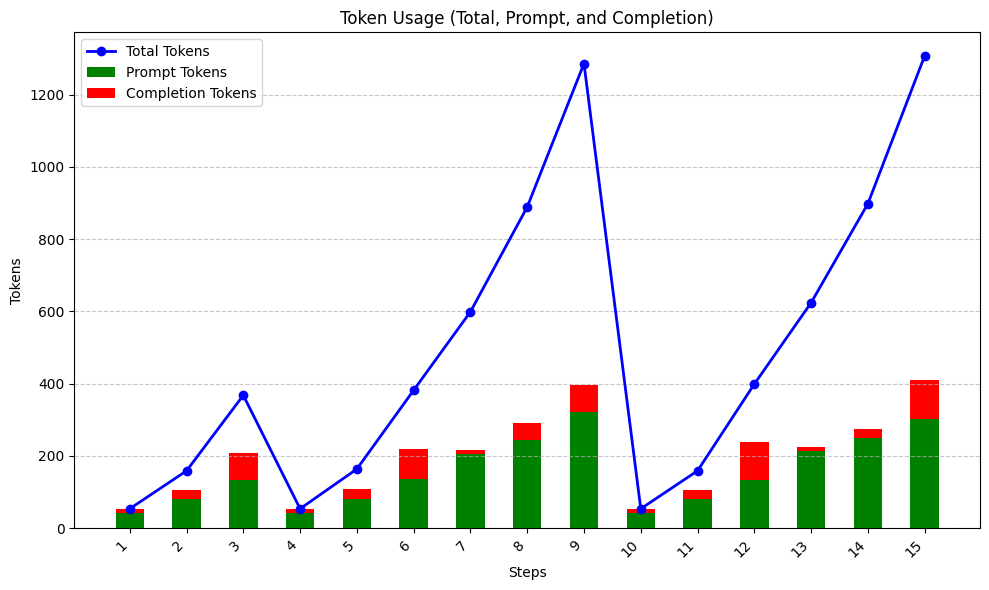

In [245]:
chat_manager.show_usage_plots()

In [246]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 13:07:23
Version 1: 2025-03-26 13:07:23
Version 2: 2025-03-26 13:07:24
Version 3: 2025-03-26 13:07:25
Version 4: 2025-03-26 13:07:30
Version 5: 2025-03-26 13:07:31
Version 6: 2025-03-26 13:07:32
Version 7: 2025-03-26 13:07:39
Version 8: 2025-03-26 13:07:40
Version 9: 2025-03-26 13:07:41
Version 10: 2025-03-26 13:07:43
Version 11: 2025-03-26 13:07:46
Version 12: 2025-03-26 13:07:47
Version 13: 2025-03-26 13:07:48
Version 14: 2025-03-26 13:07:49
Version 15: 2025-03-26 13:07:50
Version 16: 2025-03-26 13:07:50
Version 17: 2025-03-26 13:07:50
Version 18: 2025-03-26 13:07:51 (In Use) 🔵
